In [1]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from matplotlib import pyplot
from PIL import Image
import os, sys
from sklearn.model_selection import train_test_split
import numpy

In [2]:
# Define the encoder block based on the original paper
def define_encoder_block(layer, filtersNo, batchnorm=True):
    
    # init weights from a Gaussian distribution with mean 0 and standard deviation 0.02
    init = RandomNormal(stddev=0.02)
    
    # in the original paper, all convolution kernels are (4,4), with stride 2. Stride for decoder means downsampling.
    x = Conv2D(filtersNo, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer)
    
    # Conditional batch normalization (important for the first layer)
    if batchnorm:
        x = BatchNormalization()(x, training=True)
        
    # All ReLUs in the encoder are leaky!
    x = LeakyReLU(alpha=0.2)(x)
    #x = Activation('relu')(x)
    
    return x

In [3]:
# Define the decoder block based on the original paper
def decoder_block(layer, skip, filtersNo, dropout=True, batch=True):
    
    # init weights from a Gaussian distribution with mean 0 and standard deviation 0.02
    init = RandomNormal(stddev=0.02)
    
    # in the original paper, all convolution kernels are (4,4), with stride 2. Stride for decoder means upsampling.
    x = Conv2DTranspose(filtersNo, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer)

    # All layers in the original paper have batch normalization
    x = BatchNormalization()(x, training=True)
        
    # Some decoder layers don't have dropout
    if dropout:
        x = Dropout(0.5)(x, training=True)
        
    # Merge with skip connection
    x = Concatenate()([x, skip])
    
    # All ReLUs in the decoder are not leaky!
    #x = Activation('relu')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    return x

In [4]:
# Define the generator based on encoder/decoder
def define_generator(load = False):
    
    # init weights from a Gaussian distribution with mean 0 and standard deviation 0.02
    init = RandomNormal(stddev=0.02)
    
    # image input
    inputImage = Input(shape=(128,128,1))
    
    ###### Encoder
    
    # C64, input (128,128,1), output (64,64,64)
    encoderLayer1 = define_encoder_block(inputImage, 64, batchnorm=False)
    
    #C128, input (64,64,64), output (32,32,128)
    encoderLayer2 = define_encoder_block(encoderLayer1, 128)
    
    #C256, input (32,32,128), output (16,16,256)
    encoderLayer3 = define_encoder_block(encoderLayer2, 256)
    
    #C512, input (16,16,256), output (8,8,512)
    encoderLayer4 = define_encoder_block(encoderLayer3, 512)
    
    #C512, input (8,8,512), output (4,4,512)
    encoderLayer5 = define_encoder_block(encoderLayer4, 512)
    
    #C512, input (4,4,512), output (2,2,512)
    encoderLayer6 = define_encoder_block(encoderLayer5, 512)
    
    ###### Bottleneck layer, will have an input of (2,2,512) and an output of (1,1,512)
    bottleneck = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(encoderLayer6)
    bottleneck = Activation('relu')(bottleneck)
    
    ###### Decoder, with skip connection
    
    #CD512
    decoderLayer1 = decoder_block(bottleneck, encoderLayer6, 512)
    
    #CD512
    decoderLayer2 = decoder_block(decoderLayer1, encoderLayer5, 512)
    
    #C512
    decoderLayer3 = decoder_block(decoderLayer2, encoderLayer4, 512, dropout=False)
    
    #C256
    decoderLayer4 = decoder_block(decoderLayer3, encoderLayer3, 256, dropout=False)
    
    #C128
    decoderLayer5 = decoder_block(decoderLayer4, encoderLayer2, 128, dropout=False)
    
    #C64
    decoderLayer6 = decoder_block(decoderLayer5, encoderLayer1, 64, dropout=False)
    
    # Output with tanh function, as mentioned in the original paper. Output will be (128x128x3)
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(decoderLayer6)
    outputImage = Activation('tanh')(g)
    
    # Define model
    model = Model(inputImage, outputImage)
    
    if load == True:
        model.load_weights("models/model.h5")
    
    return model

In [5]:
# Define the 70x70 discriminator as in the original paper
def define_discriminator():
    
    # init weights from a Gaussian distribution with mean 0 and standard deviation 0.02
    init = RandomNormal(stddev=0.02)
    
    # source image input
    source = Input(shape=(128,128,1))
    
    # target image input
    target = Input(shape=(128,128,3))
    
    # concatenate images channel-wise
    merged = Concatenate()([source, target])
    
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # patch output
    d = Conv2D(1, (8,8), strides=(8,8), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    patch_out = Flatten()(patch_out)
    
    # define model
    model = Model([source, target], patch_out)
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [6]:
# Define Pix2Pix GAN
def pix2pix(generator, discriminator):
    
    # make weights in the discriminator not trainable
    for layer in discriminator.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
            
    # define the source image
    source = Input(shape=(128,128,1))
    
    # connect the source image to the generator input
    genOut = generator(source)
    
    # connect the source input and generator output to the discriminator input
    disOut = discriminator([source, genOut])
    
    # src image as input, generated image and classification output
    model = Model(source, [disOut, genOut])
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    
    return model

In [7]:
def generateFromDataset(trainX, trainY, samples):
    
    # Choose random images from both input and output
    no = randint(0, trainX.shape[0], samples)
    gx, gy = trainX[no], trainY[no]
    
    # Set y-labels to 1, as these images are from dataset
    y = ones((samples, 1))
    return [gx, gy], y

In [8]:
def generateFromGenerator(generator, samples):
    # Generate fake instance
    x = generator.predict(samples)
    
    # Labels will be zero because they come from the generator
    y = zeros((len(x), 1))
    
    return x, y

In [9]:
def summarize_performance(step, g_model, trainX, trainY, n_samples=5):
    # select a sample of input images
    [X_realA, X_realB], _ = generateFromDataset(trainX, trainY, n_samples)
    
    # Generate fake samples
    X_fakeB, _ = generateFromGenerator(g_model, X_realA)
    
    # Plot black and white images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i], cmap="binary")
        
    # Plot generated images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
        
    # Plot expected output images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
        
    # Save plot to file
    filename1 = 'images/plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    
    # Save generator model
    filename2 = 'models/model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [10]:
def train(discriminator, generator, gan, epochs=3000, samplesPerEpoch=250):
    
    # Load the data
    bwData = load("Flickr30kblackandwhite1dim.npy")
    colorData = load("flickr30k_shuffled.npy")

    gLoss = []
    d_realLoss = []
    d_fakeLoss = []
    
    BWSplit = numpy.array_split(bwData, 2)
    colorSplit = numpy.array_split(colorData, 2)
    glossMin = 999
    
    # manually enumerate epochs
    for i in range(epochs):
        
        # Generate real samples
        [realX, realY], realLabel = generateFromDataset(BWSplit[0], colorSplit[0], samplesPerEpoch)
        
        # Generate fake samples
        fakeY, fakeLabel = generateFromGenerator(generator, realX)
        
        # Update discriminator on real samples
        realLoss = discriminator.train_on_batch([realX, realY], realLabel)
        d_realLoss.append(realLoss)
        
        # Update discriminator on fake samples
        fakeLoss = discriminator.train_on_batch([realX, fakeY], fakeLabel)
        d_fakeLoss.append(fakeLoss)
        
        # Update generator
        generatorLoss, _, _ = gan.train_on_batch(realX, [realLabel, realY])
        gLoss.append(generatorLoss)
        
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, realLoss, fakeLoss, generatorLoss))
        if glossMin > generatorLoss:
            summarize_performance(i, generator, BWSplit[0], colorSplit[0])
            glossMin = generatorLoss
            
    return gLoss, d_realLoss, d_fakeLoss

In [11]:
def test(generator):
    # Load the data
    bwData = load("testimagesblackandwhite1dim.npy")
    colorData = load("testimages.npy")
    y = numpy.ones((8091,1))
    
    BWSplit = numpy.array_split(bwData, 2)
    colorSplit = numpy.array_split(colorData, 2)
    
    averageRed = 0
    averageGreen = 0
    averageBlue = 0
    
    generatedImages, labels = generateFromGenerator(generator, BWSplit[1])
    
    print("It will take around 2 minutes to calculate all values!")
    
    for i in range(0,len(BWSplit[1])):
        
        gImage = generatedImages[i]
        rImage = colorSplit[1][i]
        
        red = 0
        green = 0
        blue = 0
        
        for x in range(0,128):
            for y in range(0,128):
                red += abs(rImage[x][y][0]-gImage[x][y][0])
                green += abs(rImage[x][y][1]-gImage[x][y][1])
                blue += abs(rImage[x][y][2]-gImage[x][y][2])
                
        averageRed += (red/(128*128))
        averageGreen += (green/(128*128))
        averageBlue += (blue/(128*128))
        
    averageRed = averageRed/len(BWSplit[1])
    averageGreen = averageGreen/len(BWSplit[1])
    averageBlue = averageBlue/len(BWSplit[1])
    
    print(averageRed)
    print(averageGreen)
    print(averageBlue)
    

In [12]:
d = define_discriminator()
g = define_generator()
p2p = pix2pix(g,d)

In [13]:
gLoss, d_realLoss, d_fakeLoss = train(d,g,p2p)

>1, d1[0.876] d2[3.325] g[49.674]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: images/plot_000001.png and models/model_000001.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2, d1[0.000] d2[7.595] g[41.860]
>Saved: images/plot_000002.png and models/model_000002.h5
>3, d1[0.000] d2[7.593] g[42.246]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>4, d1[0.000] d2[7.246] g[39.953]
>Saved: images/plot_000004.png and models/model_000004.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>5, d1[0.002] d2[5.738] g[39.775]
>Saved: images/plot_000005.png and models/model_000005.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>6, d1[0.062] d2[5.559] g[37.845]
>Saved: images/plot_000006.png and models/model_000006.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>7, d1[0.060] d2[5.364] g[36.300]
>Saved: images/plot_000007.png and models/model_000007.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>8, d1[0.116] d2[4.937] g[34.639]
>Saved: images/plot_000008.png and models/model_000008.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>9, d1[0.110] d2[3.959] g[34.409]
>Saved: images/plot_000009.png and models/model_000009.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>10, d1[0.126] d2[3.642] g[33.590]
>Saved: images/plot_000010.png and models/model_000010.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>11, d1[0.219] d2[3.414] g[32.530]
>Saved: images/plot_000011.png and models/model_000011.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>12, d1[0.223] d2[3.138] g[29.598]
>Saved: images/plot_000012.png and models/model_000012.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>13, d1[0.170] d2[3.038] g[28.112]
>Saved: images/plot_000013.png and models/model_000013.h5
>14, d1[0.173] d2[2.543] g[25.385]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: images/plot_000014.png and models/model_000014.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>15, d1[0.140] d2[2.294] g[25.154]
>Saved: images/plot_000015.png and models/model_000015.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>16, d1[0.137] d2[2.232] g[22.896]
>Saved: images/plot_000016.png and models/model_000016.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>17, d1[0.146] d2[2.198] g[22.198]
>Saved: images/plot_000017.png and models/model_000017.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>18, d1[0.118] d2[2.038] g[21.397]
>Saved: images/plot_000018.png and models/model_000018.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>19, d1[0.147] d2[1.996] g[19.930]
>Saved: images/plot_000019.png and models/model_000019.h5
>20, d1[0.129] d2[1.802] g[20.048]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>21, d1[0.147] d2[1.779] g[18.177]
>Saved: images/plot_000021.png and models/model_000021.h5
>22, d1[0.113] d2[1.558] g[18.350]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>23, d1[0.166] d2[1.754] g[17.224]
>Saved: images/plot_000023.png and models/model_000023.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>24, d1[0.159] d2[1.632] g[15.911]
>Saved: images/plot_000024.png and models/model_000024.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>25, d1[0.156] d2[1.396] g[15.280]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: images/plot_000025.png and models/model_000025.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>26, d1[0.130] d2[1.586] g[14.611]
>Saved: images/plot_000026.png and models/model_000026.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>27, d1[0.123] d2[1.374] g[14.226]
>Saved: images/plot_000027.png and models/model_000027.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>28, d1[0.098] d2[1.378] g[13.972]
>Saved: images/plot_000028.png and models/model_000028.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>29, d1[0.142] d2[1.520] g[13.188]
>Saved: images/plot_000029.png and models/model_000029.h5
>30, d1[0.128] d2[1.318] g[13.584]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>31, d1[0.129] d2[1.391] g[12.807]
>Saved: images/plot_000031.png and models/model_000031.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>32, d1[0.150] d2[1.242] g[12.103]
>Saved: images/plot_000032.png and models/model_000032.h5
>33, d1[0.098] d2[1.346] g[12.434]
>34, d1[0.133] d2[1.301] g[12.275]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>35, d1[0.127] d2[1.225] g[11.943]
>Saved: images/plot_000035.png and models/model_000035.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>36, d1[0.112] d2[1.371] g[11.942]
>Saved: images/plot_000036.png and models/model_000036.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>37, d1[0.129] d2[1.272] g[11.816]
>Saved: images/plot_000037.png and models/model_000037.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>38, d1[0.133] d2[1.280] g[11.432]
>Saved: images/plot_000038.png and models/model_000038.h5
>39, d1[0.105] d2[1.240] g[11.686]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>40, d1[0.133] d2[1.288] g[11.196]
>Saved: images/plot_000040.png and models/model_000040.h5
>41, d1[0.120] d2[1.212] g[11.531]
>42, d1[0.132] d2[1.421] g[11.468]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>43, d1[0.147] d2[1.097] g[11.139]
>Saved: images/plot_000043.png and models/model_000043.h5
>44, d1[0.150] d2[1.266] g[11.143]
>45, d1[0.106] d2[1.224] g[11.261]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>46, d1[0.129] d2[1.259] g[11.137]
>Saved: images/plot_000046.png and models/model_000046.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>47, d1[0.126] d2[1.167] g[10.993]
>Saved: images/plot_000047.png and models/model_000047.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>48, d1[0.139] d2[1.208] g[10.814]
>Saved: images/plot_000048.png and models/model_000048.h5
>49, d1[0.124] d2[1.301] g[10.887]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>50, d1[0.146] d2[1.142] g[10.731]
>Saved: images/plot_000050.png and models/model_000050.h5
>51, d1[0.106] d2[1.263] g[10.893]
>52, d1[0.134] d2[1.204] g[10.900]
>53, d1[0.138] d2[1.063] g[10.937]
>54, d1[0.099] d2[1.392] g[11.006]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>55, d1[0.144] d2[1.028] g[10.591]
>Saved: images/plot_000055.png and models/model_000055.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>56, d1[0.121] d2[1.133] g[10.422]
>Saved: images/plot_000056.png and models/model_000056.h5
>57, d1[0.108] d2[1.354] g[10.806]
>58, d1[0.129] d2[1.016] g[10.908]
>59, d1[0.117] d2[1.163] g[10.672]
>60, d1[0.109] d2[1.215] g[10.873]
>61, d1[0.128] d2[1.056] g[10.632]
>62, d1[0.107] d2[1.202] g[10.584]
>63, d1[0.123] d2[1.153] g[10.788]
>64, d1[0.154] d2[0.942] g[10.645]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>65, d1[0.115] d2[1.213] g[10.325]
>Saved: images/plot_000065.png and models/model_000065.h5
>66, d1[0.101] d2[1.044] g[10.424]
>67, d1[0.103] d2[1.143] g[10.476]
>68, d1[0.124] d2[1.080] g[10.488]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>69, d1[0.118] d2[1.097] g[10.317]
>Saved: images/plot_000069.png and models/model_000069.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>70, d1[0.117] d2[1.089] g[10.276]
>Saved: images/plot_000070.png and models/model_000070.h5
>71, d1[0.123] d2[1.073] g[10.279]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>72, d1[0.121] d2[0.991] g[10.258]
>Saved: images/plot_000072.png and models/model_000072.h5
>73, d1[0.090] d2[1.230] g[10.331]
>74, d1[0.121] d2[0.945] g[10.450]
>75, d1[0.101] d2[1.249] g[10.261]
>76, d1[0.116] d2[0.973] g[10.345]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>77, d1[0.111] d2[1.130] g[10.051]
>Saved: images/plot_000077.png and models/model_000077.h5
>78, d1[0.107] d2[0.984] g[10.288]
>79, d1[0.103] d2[1.130] g[10.251]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>80, d1[0.102] d2[1.072] g[10.033]
>Saved: images/plot_000080.png and models/model_000080.h5
>81, d1[0.124] d2[1.018] g[10.238]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>82, d1[0.103] d2[1.020] g[9.921]
>Saved: images/plot_000082.png and models/model_000082.h5
>83, d1[0.107] d2[1.064] g[10.397]
>84, d1[0.094] d2[0.989] g[10.377]
>85, d1[0.104] d2[1.136] g[10.225]
>86, d1[0.109] d2[0.990] g[10.174]
>87, d1[0.100] d2[1.032] g[10.301]
>88, d1[0.111] d2[1.058] g[10.601]
>89, d1[0.108] d2[0.947] g[10.474]
>90, d1[0.103] d2[1.120] g[10.208]
>91, d1[0.102] d2[0.956] g[10.179]
>92, d1[0.090] d2[1.037] g[10.078]
>93, d1[0.098] d2[1.096] g[10.245]
>94, d1[0.104] d2[0.964] g[10.118]
>95, d1[0.111] d2[0.989] g[10.096]
>96, d1[0.105] d2[1.059] g[10.150]
>97, d1[0.094] d2[0.964] g[10.069]
>98, d1[0.105] d2[1.032] g[10.304]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>99, d1[0.116] d2[0.915] g[9.773]
>Saved: images/plot_000099.png and models/model_000099.h5
>100, d1[0.082] d2[1.088] g[9.872]
>101, d1[0.103] d2[1.022] g[10.260]
>102, d1[0.125] d2[0.861] g[9.777]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>103, d1[0.083] d2[1.122] g[9.730]
>Saved: images/plot_000103.png and models/model_000103.h5
>104, d1[0.085] d2[1.049] g[9.807]
>105, d1[0.116] d2[0.886] g[10.069]
>106, d1[0.106] d2[1.046] g[9.866]
>107, d1[0.091] d2[0.998] g[9.831]
>108, d1[0.104] d2[0.996] g[9.750]
>109, d1[0.101] d2[0.919] g[9.856]
>110, d1[0.092] d2[1.063] g[9.833]
>111, d1[0.094] d2[0.983] g[9.835]
>112, d1[0.104] d2[1.002] g[9.770]
>113, d1[0.088] d2[0.954] g[10.119]
>114, d1[0.102] d2[1.055] g[10.218]
>115, d1[0.116] d2[0.855] g[9.837]
>116, d1[0.086] d2[1.003] g[9.885]
>117, d1[0.083] d2[1.024] g[9.835]
>118, d1[0.105] d2[0.906] g[9.790]
>119, d1[0.105] d2[0.929] g[9.866]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>120, d1[0.080] d2[1.014] g[9.675]
>Saved: images/plot_000120.png and models/model_000120.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>121, d1[0.090] d2[0.930] g[9.612]
>Saved: images/plot_000121.png and models/model_000121.h5
>122, d1[0.097] d2[0.988] g[9.744]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>123, d1[0.112] d2[0.874] g[9.548]
>Saved: images/plot_000123.png and models/model_000123.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>124, d1[0.090] d2[1.018] g[9.485]
>Saved: images/plot_000124.png and models/model_000124.h5
>125, d1[0.094] d2[0.898] g[9.603]
>126, d1[0.101] d2[0.950] g[9.535]
>127, d1[0.092] d2[0.923] g[9.633]
>128, d1[0.087] d2[0.968] g[9.563]
>129, d1[0.096] d2[0.914] g[9.756]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>130, d1[0.089] d2[0.924] g[9.378]
>Saved: images/plot_000130.png and models/model_000130.h5
>131, d1[0.088] d2[1.027] g[9.823]
>132, d1[0.106] d2[0.819] g[9.551]
>133, d1[0.089] d2[0.994] g[9.616]
>134, d1[0.090] d2[0.895] g[9.591]
>135, d1[0.096] d2[0.957] g[9.614]
>136, d1[0.098] d2[0.868] g[9.552]
>137, d1[0.076] d2[1.045] g[9.592]
>138, d1[0.104] d2[0.919] g[9.800]
>139, d1[0.102] d2[0.836] g[9.451]
>140, d1[0.082] d2[1.074] g[9.477]
>141, d1[0.108] d2[0.832] g[9.697]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>142, d1[0.091] d2[0.900] g[9.267]
>Saved: images/plot_000142.png and models/model_000142.h5
>143, d1[0.076] d2[1.045] g[9.521]
>144, d1[0.101] d2[0.830] g[9.487]
>145, d1[0.084] d2[0.961] g[9.349]
>146, d1[0.101] d2[0.876] g[9.526]
>147, d1[0.097] d2[0.849] g[9.570]
>148, d1[0.080] d2[1.008] g[9.270]
>149, d1[0.081] d2[0.868] g[9.527]
>150, d1[0.114] d2[0.870] g[9.562]
>151, d1[0.082] d2[0.895] g[9.324]
>152, d1[0.073] d2[1.016] g[9.797]
>153, d1[0.080] d2[0.894] g[9.832]
>154, d1[0.108] d2[0.886] g[9.429]
>155, d1[0.102] d2[0.863] g[9.347]
>156, d1[0.082] d2[0.977] g[9.567]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>157, d1[0.100] d2[0.845] g[9.130]
>Saved: images/plot_000157.png and models/model_000157.h5
>158, d1[0.086] d2[0.957] g[9.493]
>159, d1[0.090] d2[0.870] g[9.208]
>160, d1[0.095] d2[0.897] g[9.153]
>161, d1[0.075] d2[0.914] g[9.729]
>162, d1[0.102] d2[0.895] g[9.740]
>163, d1[0.093] d2[0.774] g[9.538]
>164, d1[0.066] d2[1.016] g[9.758]
>165, d1[0.093] d2[0.820] g[9.160]
>166, d1[0.084] d2[0.871] g[9.191]
>167, d1[0.076] d2[0.978] g[9.459]
>168, d1[0.088] d2[0.807] g[9.725]
>169, d1[0.086] d2[0.918] g[9.246]
>170, d1[0.101] d2[0.852] g[9.330]
>171, d1[0.078] d2[0.837] g[9.646]
>172, d1[0.080] d2[0.945] g[9.595]
>173, d1[0.084] d2[0.799] g[9.458]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>174, d1[0.093] d2[0.874] g[8.902]
>Saved: images/plot_000174.png and models/model_000174.h5
>175, d1[0.078] d2[0.891] g[9.394]
>176, d1[0.081] d2[0.879] g[9.483]
>177, d1[0.083] d2[0.869] g[9.360]
>178, d1[0.079] d2[0.910] g[9.365]
>179, d1[0.098] d2[0.846] g[9.398]
>180, d1[0.083] d2[0.815] g[9.362]
>181, d1[0.069] d2[0.966] g[9.509]
>182, d1[0.094] d2[0.814] g[9.311]
>183, d1[0.087] d2[0.884] g[9.040]
>184, d1[0.081] d2[0.852] g[9.190]
>185, d1[0.065] d2[0.915] g[9.180]
>186, d1[0.100] d2[0.808] g[9.415]
>187, d1[0.082] d2[0.785] g[9.471]
>188, d1[0.054] d2[1.006] g[9.411]
>189, d1[0.082] d2[0.811] g[9.409]
>190, d1[0.089] d2[0.774] g[9.066]
>191, d1[0.065] d2[0.983] g[9.144]
>192, d1[0.086] d2[0.738] g[9.628]
>193, d1[0.085] d2[0.841] g[8.962]
>194, d1[0.062] d2[0.820] g[9.326]
>195, d1[0.080] d2[0.924] g[9.408]
>196, d1[0.072] d2[0.732] g[9.459]
>197, d1[0.069] d2[0.916] g[9.323]
>198, d1[0.076] d2[0.832] g[9.264]
>199, d1[0.079] d2[0.760] g[9.419]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>200, d1[0.084] d2[0.824] g[8.841]
>Saved: images/plot_000200.png and models/model_000200.h5
>201, d1[0.061] d2[0.831] g[9.120]
>202, d1[0.067] d2[0.872] g[9.340]
>203, d1[0.079] d2[0.791] g[9.371]
>204, d1[0.069] d2[0.840] g[9.346]
>205, d1[0.080] d2[0.833] g[9.150]
>206, d1[0.081] d2[0.798] g[8.865]
>207, d1[0.077] d2[0.823] g[9.416]
>208, d1[0.065] d2[0.803] g[9.106]
>209, d1[0.065] d2[0.861] g[9.191]
>210, d1[0.066] d2[0.822] g[9.276]
>211, d1[0.076] d2[0.785] g[9.119]
>212, d1[0.070] d2[0.835] g[9.128]
>213, d1[0.073] d2[0.784] g[9.233]
>214, d1[0.069] d2[0.781] g[9.574]
>215, d1[0.065] d2[0.778] g[9.206]
>216, d1[0.062] d2[0.823] g[9.071]
>217, d1[0.052] d2[0.912] g[9.529]
>218, d1[0.079] d2[0.734] g[9.447]
>219, d1[0.077] d2[0.807] g[9.252]
>220, d1[0.071] d2[0.807] g[9.240]
>221, d1[0.071] d2[0.801] g[9.004]
>222, d1[0.067] d2[0.823] g[9.040]
>223, d1[0.068] d2[0.767] g[8.933]
>224, d1[0.057] d2[0.811] g[9.415]
>225, d1[0.073] d2[0.755] g[9.360]
>226, d1[0.054] d2[0.757] g[9.36

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>233, d1[0.088] d2[0.950] g[8.769]
>Saved: images/plot_000233.png and models/model_000233.h5
>234, d1[0.073] d2[0.863] g[8.859]
>235, d1[0.073] d2[0.835] g[9.257]
>236, d1[0.099] d2[0.800] g[9.032]
>237, d1[0.073] d2[0.779] g[9.340]
>238, d1[0.071] d2[0.884] g[9.302]
>239, d1[0.084] d2[0.746] g[8.833]
>240, d1[0.076] d2[0.809] g[9.145]
>241, d1[0.067] d2[0.786] g[9.164]
>242, d1[0.074] d2[0.796] g[9.231]
>243, d1[0.059] d2[0.759] g[9.429]
>244, d1[0.080] d2[0.799] g[9.798]
>245, d1[0.057] d2[0.728] g[9.635]
>246, d1[0.059] d2[0.844] g[9.116]
>247, d1[0.057] d2[0.803] g[9.371]
>248, d1[0.088] d2[0.702] g[8.899]
>249, d1[0.056] d2[0.792] g[9.148]
>250, d1[0.063] d2[0.796] g[9.258]
>251, d1[0.057] d2[0.743] g[9.108]
>252, d1[0.065] d2[0.778] g[8.883]
>253, d1[0.048] d2[0.787] g[9.486]
>254, d1[0.060] d2[0.767] g[9.214]
>255, d1[0.063] d2[0.720] g[9.442]
>256, d1[0.052] d2[0.766] g[9.346]
>257, d1[0.065] d2[0.724] g[9.280]
>258, d1[0.047] d2[0.759] g[9.267]
>259, d1[0.072] d2[0.832] g[9.39

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>466, d1[0.031] d2[0.392] g[8.685]
>Saved: images/plot_000466.png and models/model_000466.h5
>467, d1[0.019] d2[0.740] g[9.011]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>468, d1[0.033] d2[0.442] g[8.548]
>Saved: images/plot_000468.png and models/model_000468.h5
>469, d1[0.018] d2[0.685] g[9.317]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>470, d1[0.037] d2[0.251] g[8.055]
>Saved: images/plot_000470.png and models/model_000470.h5
>471, d1[0.027] d2[0.873] g[9.375]
>472, d1[0.034] d2[0.408] g[9.534]
>473, d1[0.028] d2[0.765] g[8.567]
>474, d1[0.077] d2[0.526] g[9.213]
>475, d1[0.031] d2[0.570] g[9.625]
>476, d1[0.039] d2[0.763] g[9.104]
>477, d1[0.103] d2[0.267] g[8.417]
>478, d1[0.022] d2[0.655] g[9.680]
>479, d1[0.015] d2[0.567] g[8.405]
>480, d1[0.034] d2[0.259] g[9.416]
>481, d1[0.006] d2[0.861] g[8.839]
>482, d1[0.007] d2[0.914] g[9.613]
>483, d1[0.037] d2[0.184] g[9.582]
>484, d1[0.026] d2[0.529] g[8.180]
>485, d1[0.021] d2[0.952] g[9.294]
>486, d1[0.146] d2[0.137] g[8.103]
>487, d1[0.011] d2[0.860] g[9.304]
>488, d1[0.033] d2[0.332] g[9.398]
>489, d1[0.019] d2[0.648] g[9.661]
>490, d1[0.020] d2[0.481] g[9.252]
>491, d1[0.024] d2[0.570] g[9.280]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>492, d1[0.028] d2[0.365] g[7.734]
>Saved: images/plot_000492.png and models/model_000492.h5
>493, d1[0.009] d2[0.430] g[9.074]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>494, d1[0.007] d2[0.234] g[7.643]
>Saved: images/plot_000494.png and models/model_000494.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>495, d1[0.005] d2[0.561] g[7.612]
>Saved: images/plot_000495.png and models/model_000495.h5
>496, d1[0.011] d2[0.235] g[9.416]
>497, d1[0.022] d2[0.449] g[8.743]
>498, d1[0.005] d2[0.297] g[8.516]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>499, d1[0.003] d2[0.734] g[7.507]
>Saved: images/plot_000499.png and models/model_000499.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>500, d1[0.014] d2[0.167] g[7.128]
>Saved: images/plot_000500.png and models/model_000500.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>501, d1[0.023] d2[0.176] g[6.933]
>Saved: images/plot_000501.png and models/model_000501.h5
>502, d1[0.020] d2[0.242] g[7.055]
>503, d1[0.014] d2[0.082] g[7.016]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>504, d1[0.022] d2[0.173] g[6.809]
>Saved: images/plot_000504.png and models/model_000504.h5
>505, d1[0.040] d2[0.045] g[7.023]
>506, d1[0.011] d2[0.122] g[8.166]
>507, d1[0.002] d2[0.800] g[12.503]
>508, d1[0.102] d2[0.529] g[11.754]
>509, d1[0.179] d2[1.448] g[11.870]
>510, d1[0.160] d2[0.377] g[8.557]
>511, d1[0.023] d2[0.403] g[9.162]
>512, d1[0.012] d2[0.200] g[7.389]
>513, d1[0.012] d2[0.459] g[8.743]
>514, d1[0.003] d2[0.108] g[8.577]
>515, d1[0.001] d2[0.728] g[7.255]
>516, d1[0.001] d2[0.766] g[11.834]
>517, d1[0.020] d2[0.020] g[8.590]
>518, d1[0.020] d2[0.280] g[7.309]
>519, d1[0.006] d2[0.734] g[7.225]
>520, d1[0.020] d2[0.041] g[7.344]
>521, d1[0.013] d2[0.229] g[8.910]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>522, d1[0.002] d2[0.177] g[6.482]
>Saved: images/plot_000522.png and models/model_000522.h5
>523, d1[0.001] d2[0.102] g[7.603]
>524, d1[0.001] d2[0.505] g[7.147]
>525, d1[0.012] d2[0.250] g[7.895]
>526, d1[0.037] d2[0.037] g[7.759]
>527, d1[0.002] d2[0.396] g[7.098]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>528, d1[0.008] d2[0.059] g[6.451]
>Saved: images/plot_000528.png and models/model_000528.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>529, d1[0.009] d2[0.025] g[6.362]
>Saved: images/plot_000529.png and models/model_000529.h5
>530, d1[0.002] d2[0.129] g[6.755]
>531, d1[0.004] d2[0.129] g[6.565]
>532, d1[0.012] d2[0.010] g[6.472]
>533, d1[0.011] d2[0.006] g[6.565]
>534, d1[0.005] d2[0.019] g[6.382]
>535, d1[0.002] d2[0.045] g[6.621]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>536, d1[0.003] d2[0.005] g[6.318]
>Saved: images/plot_000536.png and models/model_000536.h5
>537, d1[0.002] d2[0.016] g[6.677]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>538, d1[0.002] d2[0.014] g[6.280]
>Saved: images/plot_000538.png and models/model_000538.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>539, d1[0.002] d2[0.003] g[6.154]
>Saved: images/plot_000539.png and models/model_000539.h5
>540, d1[0.001] d2[0.037] g[6.403]
>541, d1[0.001] d2[0.045] g[6.638]
>542, d1[0.028] d2[0.075] g[6.915]
>543, d1[0.004] d2[0.086] g[7.165]
>544, d1[0.000] d2[0.042] g[7.014]
>545, d1[0.000] d2[0.645] g[7.201]
>546, d1[0.002] d2[0.020] g[8.385]
>547, d1[0.000] d2[2.208] g[7.610]
>548, d1[0.023] d2[0.011] g[7.697]
>549, d1[0.096] d2[0.071] g[7.051]
>550, d1[0.001] d2[1.118] g[6.538]
>551, d1[0.002] d2[0.013] g[6.767]
>552, d1[0.009] d2[0.112] g[6.563]
>553, d1[0.007] d2[0.084] g[6.400]
>554, d1[0.007] d2[0.011] g[6.392]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>555, d1[0.011] d2[0.003] g[6.059]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: images/plot_000555.png and models/model_000555.h5
>556, d1[0.004] d2[0.011] g[6.105]
>557, d1[0.002] d2[0.018] g[6.408]
>558, d1[0.003] d2[0.006] g[6.100]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>559, d1[0.003] d2[0.011] g[6.009]
>Saved: images/plot_000559.png and models/model_000559.h5
>560, d1[0.002] d2[0.135] g[6.220]
>561, d1[0.005] d2[0.004] g[6.010]
>562, d1[0.005] d2[0.006] g[6.172]
>563, d1[0.004] d2[0.001] g[6.210]
>564, d1[0.004] d2[0.029] g[6.160]
>565, d1[0.002] d2[0.245] g[6.836]
>566, d1[1.147] d2[0.008] g[7.394]
>567, d1[0.002] d2[0.603] g[7.146]
>568, d1[0.114] d2[0.318] g[6.640]
>569, d1[0.000] d2[0.005] g[6.694]
>570, d1[0.001] d2[0.005] g[6.641]
>571, d1[0.000] d2[0.121] g[6.278]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>572, d1[0.001] d2[0.010] g[5.987]
>Saved: images/plot_000572.png and models/model_000572.h5
>573, d1[0.001] d2[0.017] g[6.236]
>574, d1[0.001] d2[0.007] g[6.161]
>575, d1[0.001] d2[0.004] g[6.063]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>576, d1[0.001] d2[0.015] g[5.986]
>Saved: images/plot_000576.png and models/model_000576.h5
>577, d1[0.001] d2[0.017] g[6.247]
>578, d1[0.001] d2[0.015] g[5.986]
>579, d1[0.001] d2[0.012] g[6.070]
>580, d1[0.001] d2[0.001] g[6.278]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>581, d1[0.001] d2[0.020] g[5.922]
>Saved: images/plot_000581.png and models/model_000581.h5
>582, d1[0.001] d2[0.027] g[5.984]
>583, d1[0.002] d2[0.009] g[6.062]
>584, d1[0.001] d2[0.001] g[6.127]
>585, d1[0.001] d2[0.006] g[6.457]
>586, d1[0.001] d2[0.000] g[6.275]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>587, d1[0.001] d2[0.010] g[5.900]
>Saved: images/plot_000587.png and models/model_000587.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>588, d1[0.001] d2[0.002] g[5.618]
>Saved: images/plot_000588.png and models/model_000588.h5
>589, d1[0.001] d2[0.002] g[5.978]
>590, d1[0.001] d2[0.003] g[5.924]
>591, d1[0.000] d2[0.008] g[6.235]
>592, d1[0.001] d2[0.014] g[5.869]
>593, d1[0.000] d2[0.015] g[5.989]
>594, d1[0.001] d2[0.010] g[6.254]
>595, d1[0.000] d2[0.001] g[6.181]
>596, d1[0.000] d2[0.002] g[6.285]
>597, d1[0.001] d2[0.008] g[6.155]
>598, d1[0.001] d2[0.000] g[6.065]
>599, d1[0.000] d2[0.002] g[6.280]
>600, d1[0.000] d2[0.058] g[6.025]
>601, d1[0.002] d2[0.003] g[5.892]
>602, d1[0.005] d2[0.003] g[8.880]
>603, d1[0.000] d2[0.350] g[6.436]
>604, d1[0.000] d2[0.016] g[6.497]
>605, d1[0.000] d2[0.089] g[6.064]
>606, d1[0.000] d2[0.021] g[6.505]
>607, d1[0.000] d2[0.021] g[6.238]
>608, d1[0.001] d2[0.004] g[6.049]
>609, d1[0.001] d2[0.014] g[6.002]
>610, d1[0.001] d2[0.009] g[5.784]
>611, d1[0.001] d2[0.008] g[6.413]
>612, d1[0.001] d2[0.004] g[5.896]
>613, d1[0.001] d2[0.011] g[5.964]
>614, d1[0.001] d2[0.002] g[5.76

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>694, d1[0.000] d2[0.001] g[5.509]
>Saved: images/plot_000694.png and models/model_000694.h5
>695, d1[0.000] d2[0.001] g[6.069]
>696, d1[0.000] d2[0.000] g[5.839]
>697, d1[0.000] d2[0.000] g[6.228]
>698, d1[0.000] d2[0.000] g[5.987]
>699, d1[0.000] d2[0.002] g[6.055]
>700, d1[0.000] d2[0.001] g[6.383]
>701, d1[0.000] d2[0.000] g[5.911]
>702, d1[0.000] d2[0.084] g[5.861]
>703, d1[0.000] d2[0.000] g[6.420]
>704, d1[0.001] d2[0.000] g[6.046]
>705, d1[0.001] d2[0.000] g[6.093]
>706, d1[0.000] d2[0.000] g[6.193]
>707, d1[0.000] d2[0.000] g[5.926]
>708, d1[0.000] d2[0.001] g[5.984]
>709, d1[0.000] d2[0.000] g[5.993]
>710, d1[0.000] d2[0.000] g[6.043]
>711, d1[0.000] d2[0.000] g[5.675]
>712, d1[0.000] d2[0.000] g[5.983]
>713, d1[0.000] d2[0.000] g[6.102]
>714, d1[0.000] d2[0.002] g[5.805]
>715, d1[0.000] d2[0.000] g[5.909]
>716, d1[0.000] d2[0.001] g[6.050]
>717, d1[0.000] d2[0.000] g[5.932]
>718, d1[0.000] d2[0.002] g[5.777]
>719, d1[0.000] d2[0.000] g[5.909]
>720, d1[0.000] d2[0.003] g[5.87

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>822, d1[0.000] d2[0.000] g[5.492]
>Saved: images/plot_000822.png and models/model_000822.h5
>823, d1[0.000] d2[0.001] g[5.507]
>824, d1[0.000] d2[0.000] g[5.851]
>825, d1[0.000] d2[0.001] g[6.045]
>826, d1[0.000] d2[0.001] g[6.067]
>827, d1[0.000] d2[0.021] g[5.816]
>828, d1[0.000] d2[0.000] g[5.918]
>829, d1[0.000] d2[0.005] g[5.767]
>830, d1[0.000] d2[0.000] g[5.696]
>831, d1[0.000] d2[0.001] g[6.030]
>832, d1[0.000] d2[0.000] g[5.922]
>833, d1[0.000] d2[0.002] g[6.071]
>834, d1[0.000] d2[0.000] g[5.683]
>835, d1[0.000] d2[0.000] g[6.222]
>836, d1[0.000] d2[0.000] g[5.570]
>837, d1[0.000] d2[0.000] g[5.787]
>838, d1[0.000] d2[0.000] g[6.054]
>839, d1[0.000] d2[0.000] g[5.831]
>840, d1[0.000] d2[0.000] g[5.701]
>841, d1[0.000] d2[0.000] g[5.852]
>842, d1[0.000] d2[0.000] g[5.856]
>843, d1[0.000] d2[0.006] g[5.896]
>844, d1[0.000] d2[0.000] g[5.668]
>845, d1[0.000] d2[0.001] g[5.950]
>846, d1[0.000] d2[0.026] g[5.963]
>847, d1[0.000] d2[0.000] g[5.749]
>848, d1[0.000] d2[0.001] g[5.89

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>864, d1[0.000] d2[0.000] g[5.485]
>Saved: images/plot_000864.png and models/model_000864.h5
>865, d1[0.000] d2[0.000] g[5.648]
>866, d1[0.000] d2[0.000] g[5.832]
>867, d1[0.000] d2[0.000] g[5.909]
>868, d1[0.000] d2[0.001] g[5.700]
>869, d1[0.000] d2[0.002] g[5.744]
>870, d1[0.000] d2[0.000] g[5.635]
>871, d1[0.000] d2[0.000] g[5.684]
>872, d1[0.000] d2[0.000] g[5.958]
>873, d1[0.000] d2[0.000] g[5.822]
>874, d1[0.000] d2[0.000] g[5.930]
>875, d1[0.000] d2[0.040] g[5.860]
>876, d1[0.000] d2[0.000] g[5.923]
>877, d1[0.001] d2[0.000] g[11.011]
>878, d1[0.000] d2[0.018] g[6.845]
>879, d1[0.000] d2[0.849] g[10.369]
>880, d1[0.000] d2[0.184] g[10.729]
>881, d1[0.000] d2[0.081] g[7.310]
>882, d1[0.000] d2[0.386] g[6.509]
>883, d1[0.000] d2[0.196] g[6.571]
>884, d1[0.000] d2[0.072] g[6.438]
>885, d1[0.000] d2[0.171] g[6.238]
>886, d1[0.003] d2[0.002] g[6.182]
>887, d1[0.001] d2[0.000] g[5.986]
>888, d1[0.001] d2[0.000] g[6.346]
>889, d1[0.001] d2[0.001] g[5.695]
>890, d1[0.001] d2[0.007] g[5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>898, d1[0.001] d2[0.001] g[5.437]
>Saved: images/plot_000898.png and models/model_000898.h5
>899, d1[0.000] d2[0.000] g[5.967]
>900, d1[0.000] d2[0.001] g[5.844]
>901, d1[0.000] d2[0.002] g[5.766]
>902, d1[0.000] d2[0.000] g[5.777]
>903, d1[0.000] d2[0.000] g[6.045]
>904, d1[0.000] d2[0.002] g[5.836]
>905, d1[0.000] d2[0.001] g[5.697]
>906, d1[0.000] d2[0.000] g[5.706]
>907, d1[0.000] d2[0.000] g[5.646]
>908, d1[0.000] d2[0.003] g[5.997]
>909, d1[0.000] d2[0.000] g[5.815]
>910, d1[0.000] d2[0.006] g[5.721]
>911, d1[0.000] d2[0.013] g[5.637]
>912, d1[0.000] d2[0.000] g[5.828]
>913, d1[0.000] d2[0.001] g[6.191]
>914, d1[0.000] d2[0.000] g[5.977]
>915, d1[0.000] d2[0.004] g[5.887]
>916, d1[0.000] d2[0.000] g[5.971]
>917, d1[0.000] d2[0.000] g[5.992]
>918, d1[0.000] d2[0.006] g[5.653]
>919, d1[0.000] d2[0.000] g[5.780]
>920, d1[0.000] d2[0.000] g[5.557]
>921, d1[0.000] d2[0.000] g[5.676]
>922, d1[0.000] d2[0.001] g[5.970]
>923, d1[0.000] d2[0.000] g[5.710]
>924, d1[0.000] d2[0.000] g[5.72

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>933, d1[0.000] d2[0.001] g[5.400]
>Saved: images/plot_000933.png and models/model_000933.h5
>934, d1[0.000] d2[0.001] g[5.717]
>935, d1[0.000] d2[0.000] g[5.677]
>936, d1[0.000] d2[0.003] g[5.871]
>937, d1[0.000] d2[0.000] g[5.558]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>938, d1[0.000] d2[0.000] g[5.388]
>Saved: images/plot_000938.png and models/model_000938.h5
>939, d1[0.000] d2[0.000] g[5.744]
>940, d1[0.000] d2[0.004] g[5.676]
>941, d1[0.000] d2[0.000] g[5.643]
>942, d1[0.000] d2[0.000] g[5.808]
>943, d1[0.000] d2[0.000] g[5.617]
>944, d1[0.000] d2[0.000] g[5.512]
>945, d1[0.000] d2[0.000] g[5.731]
>946, d1[0.000] d2[0.000] g[5.538]
>947, d1[0.000] d2[0.001] g[5.986]
>948, d1[0.000] d2[0.001] g[5.579]
>949, d1[0.000] d2[0.001] g[5.533]
>950, d1[0.000] d2[0.000] g[5.724]
>951, d1[0.000] d2[0.000] g[6.019]
>952, d1[0.000] d2[0.001] g[5.843]
>953, d1[0.000] d2[0.001] g[5.691]
>954, d1[0.000] d2[0.007] g[5.689]
>955, d1[0.000] d2[0.000] g[5.583]
>956, d1[0.000] d2[0.002] g[5.646]
>957, d1[0.000] d2[0.001] g[5.822]
>958, d1[0.000] d2[0.004] g[5.502]
>959, d1[0.000] d2[0.000] g[5.479]
>960, d1[0.000] d2[0.000] g[5.651]
>961, d1[0.000] d2[0.000] g[5.959]
>962, d1[0.000] d2[0.000] g[5.905]
>963, d1[0.000] d2[0.000] g[5.870]
>964, d1[0.000] d2[0.001] g[5.76

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1003, d1[0.000] d2[0.001] g[5.294]
>Saved: images/plot_001003.png and models/model_001003.h5
>1004, d1[0.000] d2[0.000] g[5.512]
>1005, d1[0.000] d2[0.000] g[5.344]
>1006, d1[0.000] d2[0.000] g[5.582]
>1007, d1[0.000] d2[0.004] g[5.646]
>1008, d1[0.000] d2[0.000] g[5.570]
>1009, d1[0.000] d2[0.000] g[5.919]
>1010, d1[0.000] d2[0.000] g[5.860]
>1011, d1[0.000] d2[0.000] g[5.361]
>1012, d1[0.000] d2[0.001] g[5.321]
>1013, d1[0.000] d2[0.000] g[5.801]
>1014, d1[0.000] d2[0.000] g[5.581]
>1015, d1[0.000] d2[0.001] g[5.715]
>1016, d1[0.000] d2[0.000] g[5.594]
>1017, d1[0.000] d2[0.000] g[5.790]
>1018, d1[0.000] d2[0.004] g[6.057]
>1019, d1[0.000] d2[0.001] g[6.145]
>1020, d1[0.000] d2[0.000] g[6.103]
>1021, d1[0.000] d2[0.000] g[5.597]
>1022, d1[0.000] d2[0.000] g[5.681]
>1023, d1[0.000] d2[0.000] g[5.399]
>1024, d1[0.000] d2[0.000] g[5.930]
>1025, d1[0.000] d2[0.000] g[5.670]
>1026, d1[0.000] d2[0.000] g[5.664]
>1027, d1[0.000] d2[0.000] g[5.873]
>1028, d1[0.000] d2[0.000] g[5.308]
>1029,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1072, d1[0.000] d2[0.000] g[5.235]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: images/plot_001072.png and models/model_001072.h5
>1073, d1[0.000] d2[0.000] g[5.273]
>1074, d1[0.000] d2[0.000] g[5.789]
>1075, d1[0.000] d2[0.000] g[5.720]
>1076, d1[0.000] d2[0.000] g[5.571]
>1077, d1[0.000] d2[0.000] g[5.665]
>1078, d1[0.000] d2[0.000] g[5.535]
>1079, d1[0.000] d2[0.000] g[5.689]
>1080, d1[0.000] d2[0.000] g[5.556]
>1081, d1[0.000] d2[0.000] g[5.386]
>1082, d1[0.000] d2[0.000] g[5.666]
>1083, d1[0.000] d2[0.003] g[5.557]
>1084, d1[0.000] d2[0.000] g[5.522]
>1085, d1[0.000] d2[0.000] g[5.330]
>1086, d1[0.000] d2[0.005] g[5.679]
>1087, d1[0.000] d2[0.000] g[5.463]
>1088, d1[0.000] d2[0.000] g[5.540]
>1089, d1[0.000] d2[0.000] g[5.543]
>1090, d1[0.000] d2[0.000] g[5.500]
>1091, d1[0.000] d2[0.000] g[5.429]
>1092, d1[0.000] d2[0.001] g[5.360]
>1093, d1[0.000] d2[0.000] g[5.692]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1094, d1[0.000] d2[0.000] g[5.124]
>Saved: images/plot_001094.png and models/model_001094.h5
>1095, d1[0.000] d2[0.000] g[5.466]
>1096, d1[0.000] d2[0.001] g[5.740]
>1097, d1[0.000] d2[0.000] g[5.316]
>1098, d1[0.000] d2[0.000] g[5.748]
>1099, d1[0.000] d2[0.000] g[5.528]
>1100, d1[0.000] d2[0.000] g[5.455]
>1101, d1[0.000] d2[0.000] g[5.827]
>1102, d1[0.000] d2[0.000] g[5.326]
>1103, d1[0.000] d2[0.000] g[5.586]
>1104, d1[0.000] d2[0.000] g[5.434]
>1105, d1[0.000] d2[0.000] g[5.575]
>1106, d1[0.000] d2[0.000] g[5.670]
>1107, d1[0.000] d2[0.000] g[5.547]
>1108, d1[0.000] d2[0.000] g[5.568]
>1109, d1[0.000] d2[0.000] g[5.412]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1110, d1[0.000] d2[0.001] g[5.118]
>Saved: images/plot_001110.png and models/model_001110.h5
>1111, d1[0.000] d2[0.001] g[5.574]
>1112, d1[0.000] d2[0.000] g[5.474]
>1113, d1[0.000] d2[0.000] g[5.398]
>1114, d1[0.000] d2[0.001] g[5.579]
>1115, d1[0.000] d2[0.000] g[5.348]
>1116, d1[0.000] d2[0.000] g[5.469]
>1117, d1[0.000] d2[0.006] g[5.538]
>1118, d1[0.000] d2[0.000] g[5.692]
>1119, d1[0.000] d2[0.000] g[5.731]
>1120, d1[0.000] d2[0.000] g[5.443]
>1121, d1[0.000] d2[0.002] g[5.458]
>1122, d1[0.000] d2[0.000] g[5.640]
>1123, d1[0.000] d2[0.000] g[5.366]
>1124, d1[0.000] d2[0.000] g[5.712]
>1125, d1[0.000] d2[0.000] g[5.572]
>1126, d1[0.000] d2[0.000] g[5.427]
>1127, d1[0.000] d2[0.000] g[5.441]
>1128, d1[0.000] d2[0.000] g[5.648]
>1129, d1[0.000] d2[0.000] g[5.330]
>1130, d1[0.000] d2[0.000] g[5.435]
>1131, d1[0.000] d2[0.000] g[5.430]
>1132, d1[0.000] d2[0.000] g[5.572]
>1133, d1[0.000] d2[0.001] g[5.370]
>1134, d1[0.000] d2[0.000] g[5.653]
>1135, d1[0.000] d2[0.000] g[5.377]
>1136,

>1336, d1[0.000] d2[0.004] g[5.674]
>1337, d1[0.000] d2[0.000] g[5.673]
>1338, d1[0.000] d2[0.002] g[5.656]
>1339, d1[0.000] d2[0.000] g[5.171]
>1340, d1[0.000] d2[0.001] g[5.334]
>1341, d1[0.000] d2[0.000] g[5.603]
>1342, d1[0.000] d2[0.007] g[5.862]
>1343, d1[0.000] d2[0.014] g[5.627]
>1344, d1[0.000] d2[0.000] g[5.828]
>1345, d1[0.000] d2[0.000] g[5.914]
>1346, d1[0.000] d2[0.000] g[5.787]
>1347, d1[0.000] d2[0.000] g[5.406]
>1348, d1[0.000] d2[0.000] g[5.156]
>1349, d1[0.000] d2[0.000] g[5.319]
>1350, d1[0.000] d2[0.000] g[5.438]
>1351, d1[0.000] d2[0.001] g[5.616]
>1352, d1[0.000] d2[0.000] g[5.558]
>1353, d1[0.000] d2[0.007] g[5.503]
>1354, d1[0.000] d2[0.000] g[5.501]
>1355, d1[0.000] d2[0.000] g[5.396]
>1356, d1[0.000] d2[0.000] g[5.398]
>1357, d1[0.000] d2[0.001] g[5.274]
>1358, d1[0.000] d2[0.000] g[5.403]
>1359, d1[0.000] d2[0.001] g[5.203]
>1360, d1[0.000] d2[0.000] g[5.423]
>1361, d1[0.000] d2[0.000] g[5.350]
>1362, d1[0.000] d2[0.000] g[5.437]
>1363, d1[0.000] d2[0.024] g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1404, d1[0.000] d2[0.001] g[5.061]
>Saved: images/plot_001404.png and models/model_001404.h5
>1405, d1[0.000] d2[0.001] g[5.196]
>1406, d1[0.000] d2[0.000] g[5.224]
>1407, d1[0.000] d2[0.000] g[5.199]
>1408, d1[0.000] d2[0.006] g[5.088]
>1409, d1[0.000] d2[0.000] g[5.408]
>1410, d1[0.000] d2[0.008] g[5.479]
>1411, d1[0.000] d2[0.000] g[5.413]
>1412, d1[0.000] d2[0.000] g[5.308]
>1413, d1[0.000] d2[0.000] g[5.357]
>1414, d1[0.000] d2[0.000] g[5.422]
>1415, d1[0.000] d2[0.000] g[5.417]
>1416, d1[0.000] d2[0.000] g[5.184]
>1417, d1[0.000] d2[0.000] g[5.375]
>1418, d1[0.000] d2[0.001] g[5.240]
>1419, d1[0.000] d2[0.000] g[5.446]
>1420, d1[0.000] d2[0.000] g[5.401]
>1421, d1[0.000] d2[0.005] g[5.149]
>1422, d1[0.000] d2[0.000] g[5.118]
>1423, d1[0.000] d2[0.000] g[5.754]
>1424, d1[0.000] d2[0.000] g[5.398]
>1425, d1[0.000] d2[0.000] g[5.473]
>1426, d1[0.000] d2[0.000] g[5.129]
>1427, d1[0.000] d2[0.000] g[5.092]
>1428, d1[0.000] d2[0.050] g[6.620]
>1429, d1[0.538] d2[0.149] g[10.949]
>1430

>1630, d1[0.000] d2[0.000] g[5.626]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1631, d1[0.000] d2[0.000] g[5.017]
>Saved: images/plot_001631.png and models/model_001631.h5
>1632, d1[0.000] d2[0.000] g[5.085]
>1633, d1[0.000] d2[0.000] g[5.610]
>1634, d1[0.000] d2[0.000] g[5.466]
>1635, d1[0.000] d2[0.000] g[5.357]
>1636, d1[0.000] d2[0.000] g[5.172]
>1637, d1[0.000] d2[0.001] g[5.124]
>1638, d1[0.000] d2[0.007] g[5.499]
>1639, d1[0.000] d2[0.000] g[5.240]
>1640, d1[0.000] d2[0.001] g[5.331]
>1641, d1[0.000] d2[0.001] g[5.516]
>1642, d1[0.000] d2[0.000] g[5.284]
>1643, d1[0.000] d2[0.000] g[5.224]
>1644, d1[0.000] d2[0.007] g[5.244]
>1645, d1[0.000] d2[0.002] g[5.299]
>1646, d1[0.000] d2[0.003] g[5.279]
>1647, d1[0.000] d2[0.000] g[5.484]
>1648, d1[0.000] d2[0.011] g[5.330]
>1649, d1[0.000] d2[0.001] g[5.410]
>1650, d1[0.000] d2[0.000] g[5.164]
>1651, d1[0.000] d2[0.001] g[5.301]
>1652, d1[0.000] d2[0.000] g[5.384]
>1653, d1[0.000] d2[0.016] g[5.473]
>1654, d1[0.000] d2[0.000] g[5.238]
>1655, d1[0.000] d2[0.000] g[5.240]
>1656, d1[0.000] d2[0.000] g[5.152]
>1657,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1660, d1[0.000] d2[0.000] g[4.924]
>Saved: images/plot_001660.png and models/model_001660.h5
>1661, d1[0.000] d2[0.000] g[5.342]
>1662, d1[0.000] d2[0.000] g[5.249]
>1663, d1[0.000] d2[0.000] g[5.115]
>1664, d1[0.000] d2[0.000] g[5.221]
>1665, d1[0.000] d2[0.000] g[5.412]
>1666, d1[0.000] d2[0.001] g[5.180]
>1667, d1[0.000] d2[0.000] g[4.991]
>1668, d1[0.000] d2[0.000] g[5.181]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1669, d1[0.000] d2[0.000] g[4.904]
>Saved: images/plot_001669.png and models/model_001669.h5
>1670, d1[0.000] d2[0.000] g[5.252]
>1671, d1[0.000] d2[0.006] g[5.221]
>1672, d1[0.000] d2[0.001] g[5.193]
>1673, d1[0.000] d2[0.000] g[5.372]
>1674, d1[0.000] d2[0.000] g[5.291]
>1675, d1[0.000] d2[0.000] g[5.260]
>1676, d1[0.000] d2[0.003] g[5.134]
>1677, d1[0.000] d2[0.000] g[5.141]
>1678, d1[0.000] d2[0.002] g[5.318]
>1679, d1[0.000] d2[0.000] g[5.158]
>1680, d1[0.000] d2[0.001] g[5.244]
>1681, d1[0.000] d2[0.001] g[5.382]
>1682, d1[0.000] d2[0.000] g[5.098]
>1683, d1[0.000] d2[0.001] g[5.014]
>1684, d1[0.000] d2[0.000] g[5.129]
>1685, d1[0.000] d2[0.001] g[5.121]
>1686, d1[0.000] d2[0.000] g[5.025]
>1687, d1[0.000] d2[0.001] g[4.974]
>1688, d1[0.000] d2[0.001] g[5.129]
>1689, d1[0.000] d2[0.000] g[5.151]
>1690, d1[0.000] d2[0.000] g[5.061]
>1691, d1[0.000] d2[0.000] g[5.100]
>1692, d1[0.000] d2[0.000] g[5.029]
>1693, d1[0.000] d2[0.001] g[5.367]
>1694, d1[0.000] d2[0.000] g[5.197]
>1695,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1704, d1[0.000] d2[0.000] g[4.841]
>Saved: images/plot_001704.png and models/model_001704.h5
>1705, d1[0.000] d2[0.000] g[5.364]
>1706, d1[0.000] d2[0.000] g[4.944]
>1707, d1[0.000] d2[0.000] g[5.243]
>1708, d1[0.000] d2[0.000] g[4.938]
>1709, d1[0.000] d2[0.000] g[5.270]
>1710, d1[0.000] d2[0.000] g[5.027]
>1711, d1[0.000] d2[0.000] g[5.101]
>1712, d1[0.000] d2[0.000] g[5.232]
>1713, d1[0.000] d2[0.000] g[5.405]
>1714, d1[0.000] d2[0.000] g[5.425]
>1715, d1[0.000] d2[0.000] g[5.058]
>1716, d1[0.000] d2[0.000] g[5.185]
>1717, d1[0.000] d2[0.000] g[5.260]
>1718, d1[0.000] d2[0.000] g[4.905]
>1719, d1[0.000] d2[0.000] g[5.105]
>1720, d1[0.000] d2[0.000] g[5.066]
>1721, d1[0.000] d2[0.000] g[4.898]
>1722, d1[0.000] d2[0.000] g[4.943]
>1723, d1[0.000] d2[0.000] g[5.187]
>1724, d1[0.000] d2[0.000] g[5.030]
>1725, d1[0.000] d2[0.000] g[5.135]
>1726, d1[0.000] d2[0.000] g[5.371]
>1727, d1[0.000] d2[0.000] g[5.014]
>1728, d1[0.000] d2[0.000] g[5.155]
>1729, d1[0.000] d2[0.000] g[5.202]
>1730,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1738, d1[0.000] d2[0.000] g[4.770]
>Saved: images/plot_001738.png and models/model_001738.h5
>1739, d1[0.000] d2[0.000] g[5.091]
>1740, d1[0.000] d2[0.000] g[5.021]
>1741, d1[0.000] d2[0.000] g[5.006]
>1742, d1[0.000] d2[0.000] g[5.160]
>1743, d1[0.000] d2[0.000] g[5.028]
>1744, d1[0.000] d2[0.000] g[5.110]
>1745, d1[0.000] d2[0.085] g[5.498]
>1746, d1[0.004] d2[0.000] g[12.542]
>1747, d1[0.000] d2[0.137] g[8.158]
>1748, d1[0.000] d2[0.040] g[6.084]
>1749, d1[0.000] d2[0.070] g[5.629]
>1750, d1[0.000] d2[0.294] g[8.419]
>1751, d1[0.000] d2[0.003] g[7.092]
>1752, d1[0.000] d2[0.140] g[6.277]
>1753, d1[0.000] d2[0.008] g[6.286]
>1754, d1[0.000] d2[0.042] g[5.641]
>1755, d1[0.000] d2[0.124] g[5.872]
>1756, d1[0.000] d2[0.000] g[5.596]
>1757, d1[0.000] d2[0.002] g[5.445]
>1758, d1[0.000] d2[0.207] g[5.638]
>1759, d1[0.000] d2[0.000] g[9.345]
>1760, d1[0.054] d2[0.009] g[10.789]
>1761, d1[0.000] d2[1.532] g[13.650]
>1762, d1[0.000] d2[0.107] g[12.361]
>1763, d1[0.000] d2[1.120] g[11.906]
>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1887, d1[0.001] d2[0.000] g[4.731]
>Saved: images/plot_001887.png and models/model_001887.h5
>1888, d1[0.000] d2[0.000] g[4.859]
>1889, d1[0.000] d2[0.002] g[5.138]
>1890, d1[0.000] d2[0.000] g[5.002]
>1891, d1[0.000] d2[0.006] g[5.026]
>1892, d1[0.000] d2[0.001] g[5.029]
>1893, d1[0.000] d2[0.000] g[4.960]
>1894, d1[0.000] d2[0.001] g[4.861]
>1895, d1[0.000] d2[0.000] g[5.108]
>1896, d1[0.000] d2[0.000] g[5.122]
>1897, d1[0.000] d2[0.004] g[5.187]
>1898, d1[0.000] d2[0.001] g[4.888]
>1899, d1[0.000] d2[0.002] g[4.848]
>1900, d1[0.000] d2[0.000] g[4.886]
>1901, d1[0.000] d2[0.000] g[5.139]
>1902, d1[0.000] d2[0.003] g[5.007]
>1903, d1[0.000] d2[0.019] g[4.848]
>1904, d1[0.000] d2[0.002] g[5.056]
>1905, d1[0.001] d2[0.000] g[4.964]
>1906, d1[0.001] d2[0.002] g[5.126]
>1907, d1[0.001] d2[0.001] g[4.937]
>1908, d1[0.001] d2[0.000] g[4.961]
>1909, d1[0.001] d2[0.001] g[5.032]
>1910, d1[0.000] d2[0.000] g[4.766]
>1911, d1[0.000] d2[0.000] g[4.909]
>1912, d1[0.000] d2[0.001] g[4.966]
>1913,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: images/plot_001942.png and models/model_001942.h5
>1943, d1[0.000] d2[0.000] g[4.991]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1944, d1[0.000] d2[0.000] g[4.557]
>Saved: images/plot_001944.png and models/model_001944.h5
>1945, d1[0.000] d2[0.000] g[4.849]
>1946, d1[0.000] d2[0.001] g[4.699]
>1947, d1[0.000] d2[0.000] g[4.916]
>1948, d1[0.000] d2[0.001] g[4.733]
>1949, d1[0.000] d2[0.003] g[4.960]
>1950, d1[0.000] d2[0.000] g[4.788]
>1951, d1[0.000] d2[0.000] g[4.840]
>1952, d1[0.000] d2[0.001] g[5.073]
>1953, d1[0.000] d2[0.000] g[4.773]
>1954, d1[0.000] d2[0.000] g[4.769]
>1955, d1[0.000] d2[0.000] g[4.878]
>1956, d1[0.000] d2[0.000] g[4.955]
>1957, d1[0.000] d2[0.000] g[4.789]
>1958, d1[0.000] d2[0.000] g[4.864]
>1959, d1[0.000] d2[0.000] g[4.838]
>1960, d1[0.000] d2[0.054] g[4.837]
>1961, d1[0.001] d2[0.001] g[5.047]
>1962, d1[0.000] d2[0.000] g[5.083]
>1963, d1[0.001] d2[0.000] g[5.970]
>1964, d1[0.000] d2[0.001] g[9.328]
>1965, d1[0.000] d2[1.382] g[10.149]
>1966, d1[0.000] d2[0.001] g[14.247]
>1967, d1[0.000] d2[0.246] g[6.705]
>1968, d1[0.000] d2[0.005] g[6.192]
>1969, d1[0.000] d2[0.019] g[6.112]
>197

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2111, d1[0.000] d2[0.001] g[4.531]
>Saved: images/plot_002111.png and models/model_002111.h5
>2112, d1[0.000] d2[0.001] g[4.763]
>2113, d1[0.000] d2[0.000] g[4.555]
>2114, d1[0.000] d2[0.000] g[4.629]
>2115, d1[0.000] d2[0.000] g[4.726]
>2116, d1[0.000] d2[0.000] g[4.720]
>2117, d1[0.000] d2[0.000] g[4.798]
>2118, d1[0.000] d2[0.000] g[4.643]
>2119, d1[0.000] d2[0.000] g[4.615]
>2120, d1[0.000] d2[0.001] g[4.939]
>2121, d1[0.000] d2[0.000] g[4.752]
>2122, d1[0.000] d2[0.000] g[4.951]
>2123, d1[0.000] d2[0.000] g[4.604]
>2124, d1[0.000] d2[0.000] g[4.820]
>2125, d1[0.000] d2[0.000] g[4.819]
>2126, d1[0.000] d2[0.000] g[4.926]
>2127, d1[0.000] d2[0.000] g[4.717]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2128, d1[0.000] d2[0.000] g[4.507]
>Saved: images/plot_002128.png and models/model_002128.h5
>2129, d1[0.000] d2[0.000] g[4.870]
>2130, d1[0.000] d2[0.000] g[4.751]
>2131, d1[0.000] d2[0.000] g[4.819]
>2132, d1[0.000] d2[0.000] g[4.767]
>2133, d1[0.000] d2[0.000] g[5.008]
>2134, d1[0.000] d2[0.000] g[4.618]
>2135, d1[0.000] d2[0.000] g[4.663]
>2136, d1[0.000] d2[0.000] g[4.785]
>2137, d1[0.000] d2[0.000] g[4.809]
>2138, d1[0.000] d2[0.000] g[4.767]
>2139, d1[0.000] d2[0.000] g[4.673]
>2140, d1[0.000] d2[0.000] g[4.626]
>2141, d1[0.000] d2[0.000] g[4.687]
>2142, d1[0.000] d2[0.000] g[4.839]
>2143, d1[0.000] d2[0.000] g[4.782]
>2144, d1[0.000] d2[0.000] g[4.756]
>2145, d1[0.000] d2[0.001] g[4.674]
>2146, d1[0.000] d2[0.000] g[4.763]
>2147, d1[0.000] d2[0.000] g[4.548]
>2148, d1[0.000] d2[0.000] g[4.883]
>2149, d1[0.000] d2[0.000] g[4.898]
>2150, d1[0.000] d2[0.000] g[4.754]
>2151, d1[0.000] d2[0.000] g[4.999]
>2152, d1[0.000] d2[0.000] g[4.620]
>2153, d1[0.000] d2[0.000] g[4.711]
>2154,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2277, d1[0.000] d2[0.000] g[4.480]
>Saved: images/plot_002277.png and models/model_002277.h5
>2278, d1[0.000] d2[0.000] g[4.691]
>2279, d1[0.000] d2[0.000] g[4.649]
>2280, d1[0.000] d2[0.000] g[4.922]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2281, d1[0.000] d2[0.000] g[4.441]
>Saved: images/plot_002281.png and models/model_002281.h5
>2282, d1[0.000] d2[0.000] g[4.935]
>2283, d1[0.000] d2[0.000] g[5.031]
>2284, d1[0.000] d2[0.000] g[4.724]
>2285, d1[0.000] d2[0.000] g[4.868]
>2286, d1[0.000] d2[0.001] g[4.821]
>2287, d1[0.000] d2[0.001] g[4.828]
>2288, d1[0.000] d2[0.000] g[4.597]
>2289, d1[0.000] d2[0.000] g[4.657]
>2290, d1[0.000] d2[0.000] g[4.617]
>2291, d1[0.000] d2[0.000] g[4.783]
>2292, d1[0.000] d2[0.001] g[4.765]
>2293, d1[0.000] d2[0.000] g[4.647]
>2294, d1[0.000] d2[0.000] g[4.577]
>2295, d1[0.000] d2[0.000] g[4.617]
>2296, d1[0.000] d2[0.000] g[4.594]
>2297, d1[0.000] d2[0.000] g[4.745]
>2298, d1[0.000] d2[0.000] g[4.697]
>2299, d1[0.000] d2[0.000] g[4.525]
>2300, d1[0.000] d2[0.006] g[4.524]
>2301, d1[0.000] d2[0.000] g[4.708]
>2302, d1[0.000] d2[0.000] g[4.577]
>2303, d1[0.000] d2[0.000] g[4.683]
>2304, d1[0.000] d2[0.000] g[4.664]
>2305, d1[0.000] d2[0.000] g[4.655]
>2306, d1[0.000] d2[0.000] g[4.731]
>2307,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2310, d1[0.000] d2[0.000] g[4.438]
>Saved: images/plot_002310.png and models/model_002310.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2311, d1[0.000] d2[0.000] g[4.271]
>Saved: images/plot_002311.png and models/model_002311.h5
>2312, d1[0.000] d2[0.000] g[4.366]
>2313, d1[0.000] d2[0.000] g[4.367]
>2314, d1[0.000] d2[0.000] g[4.592]
>2315, d1[0.000] d2[0.000] g[4.475]
>2316, d1[0.000] d2[0.099] g[4.480]
>2317, d1[0.000] d2[0.000] g[4.800]
>2318, d1[0.007] d2[0.000] g[6.069]
>2319, d1[2.546] d2[0.697] g[7.005]
>2320, d1[0.000] d2[1.262] g[14.361]
>2321, d1[0.000] d2[0.053] g[14.299]
>2322, d1[0.000] d2[0.044] g[9.424]
>2323, d1[0.000] d2[1.710] g[13.255]
>2324, d1[0.001] d2[0.002] g[15.154]
>2325, d1[0.004] d2[0.229] g[8.427]
>2326, d1[0.001] d2[0.068] g[7.490]
>2327, d1[0.001] d2[0.129] g[6.939]
>2328, d1[0.001] d2[0.132] g[6.837]
>2329, d1[0.002] d2[0.006] g[6.536]
>2330, d1[0.006] d2[0.001] g[6.308]
>2331, d1[0.001] d2[0.001] g[6.262]
>2332, d1[0.000] d2[0.001] g[5.969]
>2333, d1[0.000] d2[0.000] g[5.804]
>2334, d1[0.000] d2[0.001] g[5.957]
>2335, d1[0.000] d2[0.001] g[6.018]
>2336, d1[0.000] d2[0.003] g[5.537]
>2

>2537, d1[0.000] d2[0.000] g[4.750]
>2538, d1[0.000] d2[0.000] g[4.791]
>2539, d1[0.000] d2[0.000] g[4.448]
>2540, d1[0.000] d2[0.000] g[4.632]
>2541, d1[0.000] d2[0.000] g[4.627]
>2542, d1[0.000] d2[0.000] g[4.562]
>2543, d1[0.000] d2[0.000] g[4.631]
>2544, d1[0.000] d2[0.001] g[4.481]
>2545, d1[0.000] d2[0.000] g[4.580]
>2546, d1[0.000] d2[0.000] g[4.687]
>2547, d1[0.000] d2[0.000] g[4.363]
>2548, d1[0.000] d2[0.000] g[4.534]
>2549, d1[0.000] d2[0.000] g[4.830]
>2550, d1[0.000] d2[0.000] g[4.444]
>2551, d1[0.000] d2[0.000] g[4.527]
>2552, d1[0.000] d2[0.000] g[4.612]
>2553, d1[0.000] d2[0.000] g[4.597]
>2554, d1[0.000] d2[0.000] g[4.700]
>2555, d1[0.000] d2[0.000] g[4.497]
>2556, d1[0.000] d2[0.000] g[4.572]
>2557, d1[0.000] d2[0.000] g[4.799]
>2558, d1[0.000] d2[0.000] g[4.543]
>2559, d1[0.000] d2[0.000] g[4.514]
>2560, d1[0.000] d2[0.000] g[4.545]
>2561, d1[0.000] d2[0.000] g[4.477]
>2562, d1[0.000] d2[0.000] g[4.562]
>2563, d1[0.000] d2[0.000] g[4.572]
>2564, d1[0.000] d2[0.000] g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2703, d1[0.000] d2[0.000] g[4.258]
>Saved: images/plot_002703.png and models/model_002703.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2704, d1[0.000] d2[0.000] g[4.252]
>Saved: images/plot_002704.png and models/model_002704.h5
>2705, d1[0.000] d2[0.000] g[4.766]
>2706, d1[0.000] d2[0.000] g[4.419]
>2707, d1[0.000] d2[0.000] g[4.445]
>2708, d1[0.000] d2[0.000] g[4.547]
>2709, d1[0.000] d2[0.000] g[4.456]
>2710, d1[0.000] d2[0.000] g[4.731]
>2711, d1[0.000] d2[0.000] g[4.360]
>2712, d1[0.000] d2[0.000] g[4.587]
>2713, d1[0.000] d2[0.000] g[4.576]
>2714, d1[0.000] d2[0.000] g[4.261]
>2715, d1[0.000] d2[0.000] g[4.594]
>2716, d1[0.000] d2[0.000] g[4.415]
>2717, d1[0.000] d2[0.000] g[4.266]
>2718, d1[0.000] d2[0.000] g[4.504]
>2719, d1[0.000] d2[0.000] g[4.469]
>2720, d1[0.000] d2[0.000] g[4.476]
>2721, d1[0.000] d2[0.000] g[4.385]
>2722, d1[0.000] d2[0.000] g[4.426]
>2723, d1[0.000] d2[0.000] g[4.435]
>2724, d1[0.000] d2[0.000] g[4.428]
>2725, d1[0.000] d2[0.000] g[4.487]
>2726, d1[0.000] d2[0.000] g[4.651]
>2727, d1[0.000] d2[0.000] g[4.514]
>2728, d1[0.000] d2[0.000] g[4.451]
>2729, d1[0.000] d2[0.000] g[4.447]
>2730,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2732, d1[0.000] d2[0.000] g[4.251]
>Saved: images/plot_002732.png and models/model_002732.h5
>2733, d1[0.000] d2[0.000] g[4.489]
>2734, d1[0.000] d2[0.101] g[4.484]
>2735, d1[0.000] d2[0.000] g[5.398]
>2736, d1[4.458] d2[0.137] g[7.628]
>2737, d1[0.001] d2[2.396] g[15.785]
>2738, d1[1.083] d2[1.189] g[13.865]
>2739, d1[0.002] d2[0.233] g[11.192]
>2740, d1[0.001] d2[0.575] g[17.386]
>2741, d1[0.844] d2[1.628] g[14.435]
>2742, d1[0.120] d2[0.312] g[12.181]
>2743, d1[0.031] d2[1.023] g[12.287]
>2744, d1[0.306] d2[0.358] g[8.336]
>2745, d1[0.020] d2[0.069] g[7.982]
>2746, d1[0.002] d2[0.870] g[9.034]
>2747, d1[0.024] d2[0.008] g[13.516]
>2748, d1[0.002] d2[0.272] g[11.583]
>2749, d1[0.000] d2[0.542] g[9.900]
>2750, d1[0.000] d2[0.466] g[7.426]
>2751, d1[0.036] d2[0.068] g[7.457]
>2752, d1[0.002] d2[0.005] g[6.796]
>2753, d1[0.000] d2[0.024] g[6.093]
>2754, d1[0.000] d2[0.012] g[6.010]
>2755, d1[0.000] d2[0.018] g[6.124]
>2756, d1[0.000] d2[0.009] g[6.068]
>2757, d1[0.000] d2[0.065] g[5.62

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2910, d1[0.000] d2[0.000] g[4.204]
>Saved: images/plot_002910.png and models/model_002910.h5
>2911, d1[0.000] d2[0.000] g[4.425]
>2912, d1[0.000] d2[0.000] g[4.531]
>2913, d1[0.000] d2[0.000] g[4.526]
>2914, d1[0.000] d2[0.000] g[4.520]
>2915, d1[0.000] d2[0.000] g[4.506]
>2916, d1[0.000] d2[0.000] g[4.331]
>2917, d1[0.000] d2[0.000] g[4.351]
>2918, d1[0.000] d2[0.000] g[4.624]
>2919, d1[0.000] d2[0.001] g[4.562]
>2920, d1[0.000] d2[0.000] g[4.559]
>2921, d1[0.000] d2[0.000] g[4.566]
>2922, d1[0.000] d2[0.000] g[4.462]
>2923, d1[0.000] d2[0.000] g[4.404]
>2924, d1[0.000] d2[0.000] g[4.452]
>2925, d1[0.000] d2[0.000] g[4.450]
>2926, d1[0.000] d2[0.002] g[4.399]
>2927, d1[0.000] d2[0.000] g[4.509]
>2928, d1[0.000] d2[0.000] g[4.245]
>2929, d1[0.000] d2[0.000] g[4.536]
>2930, d1[0.000] d2[0.000] g[4.384]
>2931, d1[0.000] d2[0.002] g[4.656]
>2932, d1[0.000] d2[0.001] g[4.368]
>2933, d1[0.000] d2[0.000] g[4.399]
>2934, d1[0.000] d2[0.000] g[4.576]
>2935, d1[0.000] d2[0.000] g[4.386]
>2936,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2938, d1[0.000] d2[0.000] g[4.175]
>Saved: images/plot_002938.png and models/model_002938.h5
>2939, d1[0.000] d2[0.000] g[4.317]
>2940, d1[0.000] d2[0.000] g[4.206]
>2941, d1[0.000] d2[0.000] g[4.399]
>2942, d1[0.000] d2[0.000] g[4.243]
>2943, d1[0.000] d2[0.003] g[4.278]
>2944, d1[0.000] d2[0.002] g[4.383]
>2945, d1[0.000] d2[0.000] g[4.453]
>2946, d1[0.000] d2[0.000] g[4.593]
>2947, d1[0.000] d2[0.000] g[4.334]
>2948, d1[0.000] d2[0.001] g[4.509]
>2949, d1[0.000] d2[0.000] g[4.508]
>2950, d1[0.000] d2[0.000] g[4.362]
>2951, d1[0.000] d2[0.000] g[4.257]
>2952, d1[0.000] d2[0.000] g[4.676]
>2953, d1[0.000] d2[0.000] g[4.436]
>2954, d1[0.000] d2[0.000] g[4.453]
>2955, d1[0.000] d2[0.000] g[4.445]
>2956, d1[0.000] d2[0.000] g[4.425]
>2957, d1[0.000] d2[0.000] g[4.468]
>2958, d1[0.000] d2[0.000] g[4.635]
>2959, d1[0.000] d2[0.000] g[4.351]
>2960, d1[0.000] d2[0.000] g[4.620]
>2961, d1[0.000] d2[0.000] g[4.382]
>2962, d1[0.000] d2[0.000] g[4.430]
>2963, d1[0.000] d2[0.000] g[4.512]
>2964,

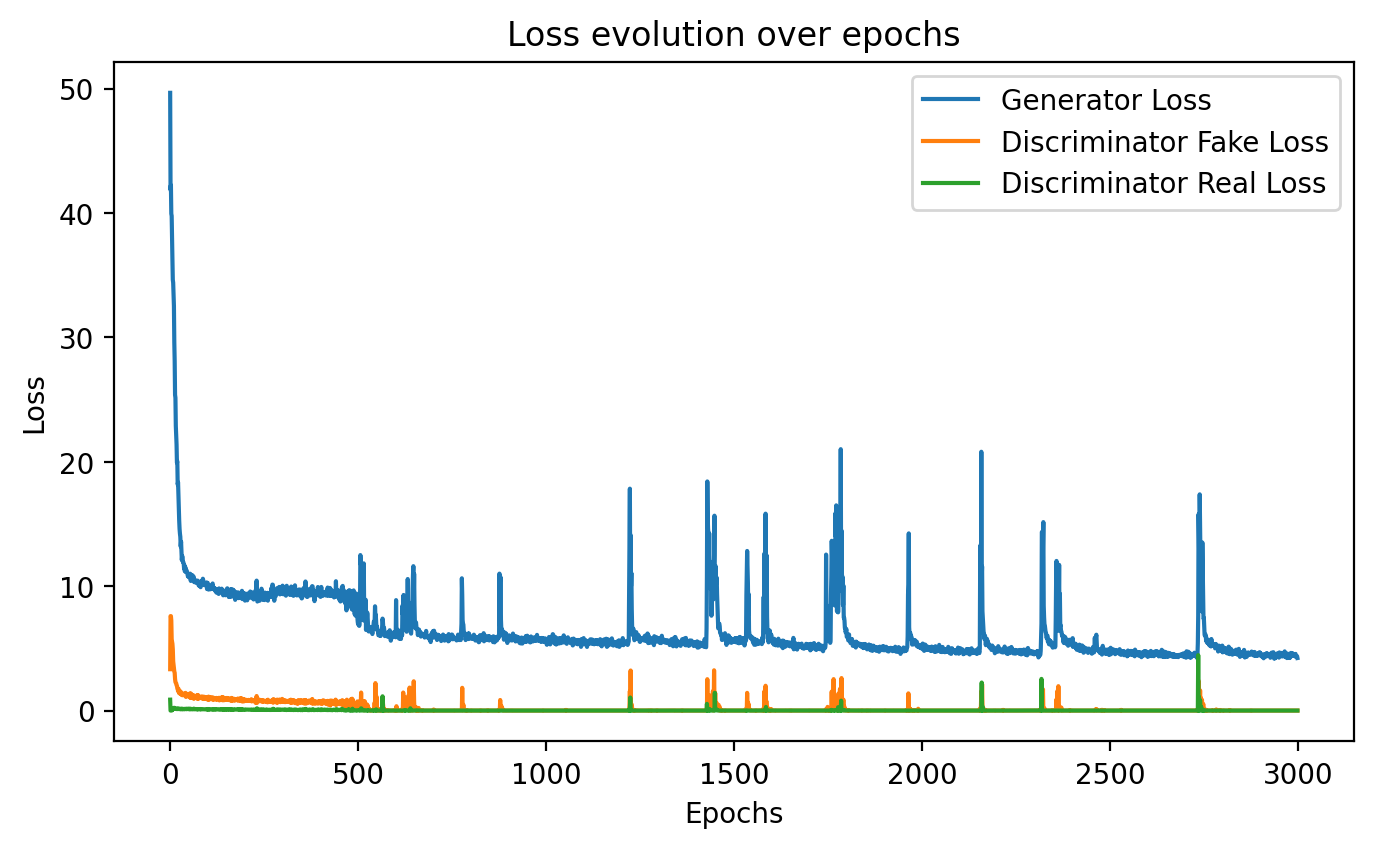

In [14]:
pyplot.figure(figsize=(8,4.5), dpi=200)
pyplot.plot(gLoss)
pyplot.plot(d_fakeLoss)
pyplot.plot(d_realLoss)
pyplot.ylabel("Loss")
pyplot.xlabel("Epochs")
pyplot.title("Loss evolution over epochs")
pyplot.legend(["Generator Loss", "Discriminator Fake Loss", "Discriminator Real Loss"])

In [16]:
g = define_generator(load = True)

In [17]:
test(g)

It will take around 2 minutes to calculate all values!
0.11336381116437542
0.06094511579586618
0.13370890669194296


In [56]:
bwData = load("testimagesblackandwhite1dim.npy")
colorData = load("testimages.npy")

bw = []
color = []

for x in range (0,7):
    bw.append(bwData[x])
    color.append(colorData[x])
    
summarize_performance(0, g, numpy.array(bw), numpy.array(color))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: images/plot_000001.png and models/model_000001.h5
